In [2]:
import sys
sys.path.append('..')

from lib.models.transformer import AlgorithmDistillationTransformer

In [3]:
# Load the trained model from checkpoint
from pipeline.run_pipeline import EconomicPolicyModel

checkpoint_path = "../checkpoints/epoch=197-val_loss=0.04.ckpt"  # Adjust path as needed

# Load weights from checkpoint
policy_model = EconomicPolicyModel.load_from_checkpoint(checkpoint_path)

# Set model to evaluation mode
policy_model.eval()

/home/jovyan/.mlspace/envs/al/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EconomicPolicyModel(
  (model): AlgorithmDistillationTransformer(
    (state_embedding): Embedding(103, 31)
    (action_embedding): Embedding(8, 31)
    (reward_embedding): Linear(in_features=1, out_features=32, bias=True)
    (task_embedding): Embedding(12, 27)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1120, out_features=1120, bias=True)
          )
          (linear1): Linear(in_features=1120, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=1120, bias=True)
          (norm1): LayerNorm((1120,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1120,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
  

In [42]:
%load_ext autoreload
%autoreload 2

from lib.envs.ramsey import RamseyEnv

env = RamseyEnv(
    alpha=0.33,
    beta=0.96,
    delta=0.1,
    start_capital=1.0
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import torch

from lib.dataset import ACTION_MAPPING, STATE_MAPPING

state_history = [torch.tensor([1] + [0] * (30 - 1), dtype=torch.float32), torch.tensor([1] + [0] * (30 - 1), dtype=torch.float32)]
action_history = [torch.tensor([0] + [0] * (3 - 1), dtype=torch.float32)]
reward_history = [torch.tensor([0], dtype=torch.float32)]

model_params = torch.tensor([0.33, 0.96, 0.1, 50, 1.0], dtype=torch.float32)
task_ids = torch.tensor([0], dtype=torch.long)

states_info = torch.tensor([STATE_MAPPING[state] for state in ["Capital"]] + [0] * (30 - 1), dtype=torch.long)
actions_info = torch.tensor([ACTION_MAPPING[action] for action in ["Consumption"]] + [0] * (3 - 1), dtype=torch.long)

state_to_plot = []
action_to_plot = []

env.reset()
for i in range(50):
    out = policy_model.forward(
        states=torch.stack(state_history).unsqueeze(0).to(policy_model.device),
        states_info=states_info.unsqueeze(0).to(policy_model.device),
        actions=torch.stack(action_history + [torch.tensor([0] * 3, dtype=torch.float32)]).unsqueeze(0).to(policy_model.device),
        actions_info=actions_info.unsqueeze(0).to(policy_model.device),
        rewards=torch.stack(reward_history + [torch.tensor([0], dtype=torch.float32)]).unsqueeze(0).to(policy_model.device),
        task_ids=task_ids.to(policy_model.device),
        model_params=model_params.unsqueeze(0).to(policy_model.device)
    )

    action = float(out[0, -1, 0])
    
    state, reward, done, truncated, info = env.step(action)
    reward_history.append(torch.tensor([reward], dtype=torch.float32))
    action_history.append(torch.tensor([action, 0, 0], dtype=torch.float32))
    state_history.append(torch.tensor([state["Capital"][0]] + [0] * (30 - 1), dtype=torch.float32))

    state_to_plot.append(state["Capital"][0] + action)
    action_to_plot.append(action)

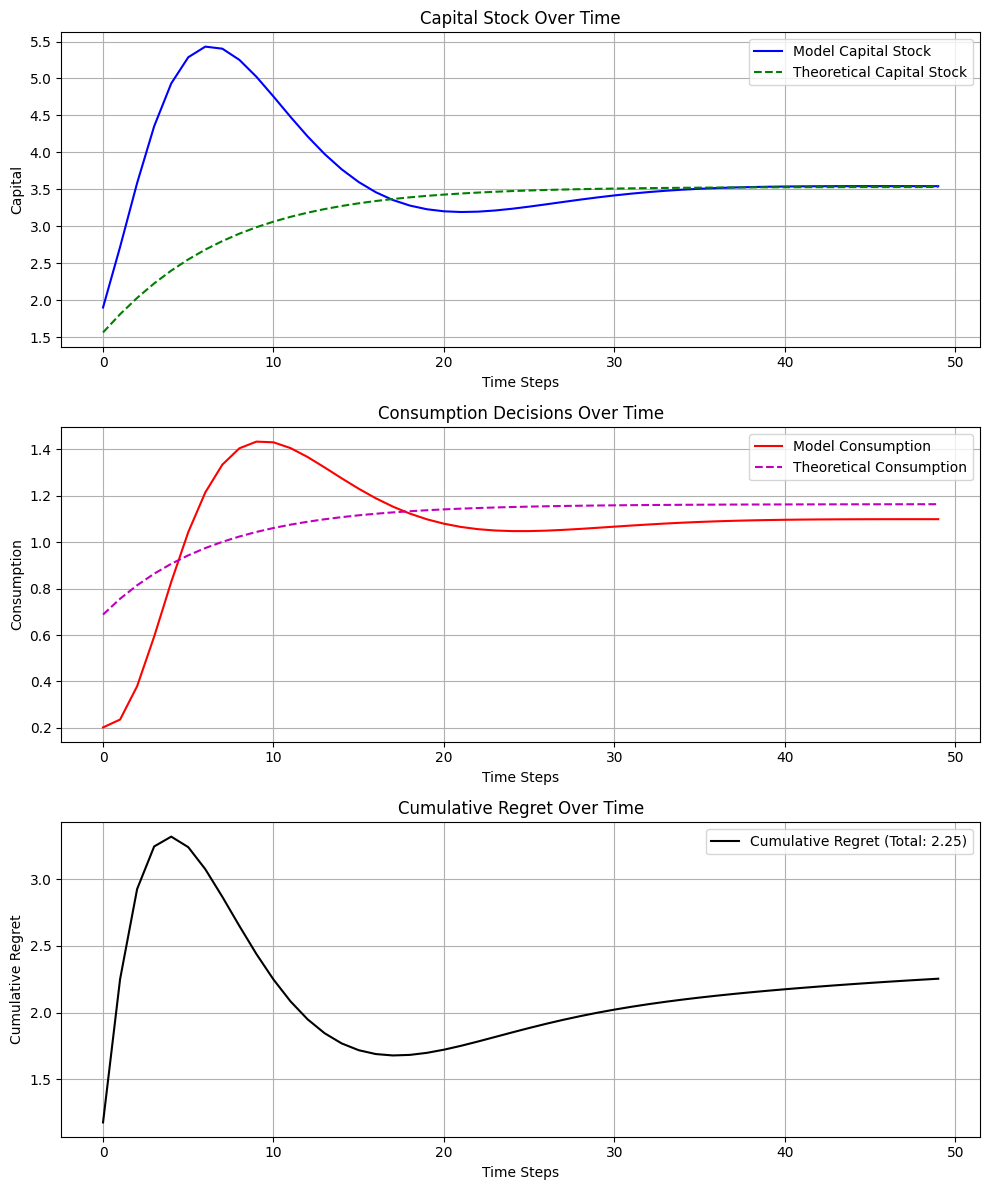

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load theoretical data
data = pd.read_csv("../theoretical_ramsey.csv", header=None).iloc[2:, :].reset_index(drop=True)
data.columns = ["Consumption", "Capital", "Output", "Investment"]

# Calculate regret as difference in utility
def calculate_utility(consumption):
    return np.log(consumption) * np.cumprod(np.array([0.96] * 50))

theoretical_utility = calculate_utility(data['Consumption']).sum()
model_utility = calculate_utility(np.array(action_to_plot)).sum()
regret = theoretical_utility - model_utility

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot capital stock
ax1.plot(state_to_plot, 'b-', label='Model Capital Stock')
ax1.plot(data['Capital'], 'g--', label='Theoretical Capital Stock')
ax1.set_title('Capital Stock Over Time')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Capital')
ax1.grid(True)
ax1.legend()

# Plot consumption decisions
ax2.plot(action_to_plot, 'r-', label='Model Consumption')
ax2.plot(data['Consumption'], 'm--', label='Theoretical Consumption')
ax2.set_title('Consumption Decisions Over Time')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Consumption')
ax2.grid(True)
ax2.legend()

# Plot cumulative regret
cumulative_regret = np.cumsum(calculate_utility(data['Consumption']) - calculate_utility(np.array(action_to_plot)))
ax3.plot(cumulative_regret, 'k-', label=f'Cumulative Regret (Total: {regret:.2f})')
ax3.set_title('Cumulative Regret Over Time')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Cumulative Regret')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()


In [63]:
from lib.dynare_traj2rl_transitions import run_model
from pathlib import Path
import pandas as pd
# run_model(
#     input_file=Path("ramsey.mod"),
#     output_file=Path("theoretical_ramsey.csv"),
#     parameters=["-Dalpha=0.33", "-Dbeta=0.96", "-Ddelta=0.1", "-Dstart_capital=1.0"],
#     max_retries=3
# )

data.head()

,Consumption,Capital,Output,Investment
0,0.000000,1.000000,0.000000,0.000000
1,0.608361,1.291639,1.000000,0.391639
2,0.687985,1.562610,1.088120,0.400135
3,0.756034,1.809014,1.158699,0.402665
4,0.814219,2.029956,1.216062,0.401843


In [75]:
import torch

from lib.dataset import ACTION_MAPPING, STATE_MAPPING

state_history = [torch.tensor([1] + [0] * (30 - 1), dtype=torch.float32), torch.tensor([1] + [0] * (30 - 1), dtype=torch.float32)]
action_history = [torch.tensor([0] + [0] * (3 - 1), dtype=torch.float32)]
reward_history = [torch.tensor([0], dtype=torch.float32)]

model_params = torch.tensor([0.33, 0.96, 0.1, 50, 1.0], dtype=torch.float32)
task_ids = torch.tensor([0], dtype=torch.long)

states_info = torch.tensor([STATE_MAPPING[state] for state in ["Capital"]] + [0] * (30 - 1), dtype=torch.long)
actions_info = torch.tensor([ACTION_MAPPING[action] for action in ["Consumption"]] + [0] * (3 - 1), dtype=torch.long)

state_to_plot = []
action_to_plot = []

env = RamseyEnv(
    alpha=0.33,
    beta=0.96,
    delta=0.1,
    start_capital=1.0
)
env.reset()
for i in range(50):
    out = policy_model.forward(
        states=torch.stack(state_history).unsqueeze(0).to(policy_model.device),
        states_info=states_info.unsqueeze(0).to(policy_model.device),
        actions=torch.stack(action_history + [torch.tensor([0] * 3, dtype=torch.float32)]).unsqueeze(0).to(policy_model.device),
        actions_info=actions_info.unsqueeze(0).to(policy_model.device),
        rewards=torch.stack(reward_history + [torch.tensor([0], dtype=torch.float32)]).unsqueeze(0).to(policy_model.device),
        task_ids=task_ids.to(policy_model.device),
        model_params=model_params.unsqueeze(0).to(policy_model.device)
    )

    action = float(out[0, -1, 0])
    
    state, reward, done, truncated, info = env.step(action)
    reward_history.append(torch.tensor([reward], dtype=torch.float32))
    action_history.append(torch.tensor([action, 0, 0], dtype=torch.float32))
    state_history.append(torch.tensor([state["Capital"][0]] + [0] * (30 - 1), dtype=torch.float32))

    state_to_plot.append(state["Capital"][0] + action)
    action_to_plot.append(action)

    if i == 25:
        env.alpha = 0.5

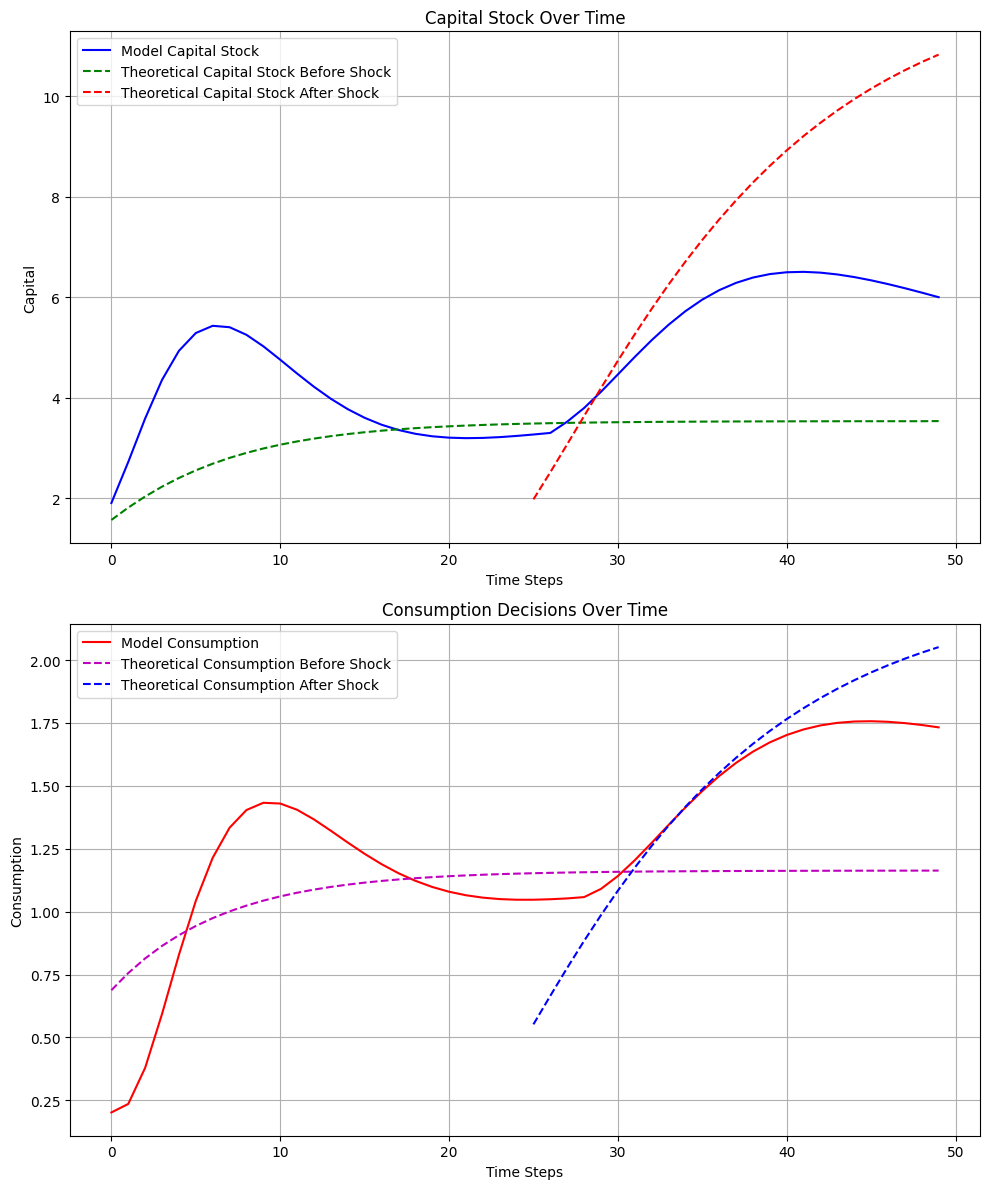

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load theoretical data
old_data = pd.read_csv("../theoretical_ramsey.csv", header=None).iloc[2:, :].reset_index(drop=True)
new_data = pd.read_csv("../theoretical_ramsey_0.5.csv", header=None).iloc[2:, :].reset_index(drop=True)
new_data.columns = ["Consumption", "Capital", "Output", "Investment"]
data.columns = ["Consumption", "Capital", "Output", "Investment"]

model_utility = calculate_utility(np.array(action_to_plot)).sum()
regret = theoretical_utility - model_utility

# Create figure with 3 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot capital stock
ax1.plot(state_to_plot, 'b-', label='Model Capital Stock')
ax1.plot(range(25), data['Capital'].iloc[:25], 'g--', label='Theoretical Capital Stock Before Shock')
ax1.plot(range(25, len(new_data)), new_data['Capital'].iloc[:25], 'r--', label='Theoretical Capital Stock After Shock')
ax1.set_title('Capital Stock Over Time')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Capital')
ax1.grid(True)
ax1.legend()

# Plot consumption decisions
ax2.plot(action_to_plot, 'r-', label='Model Consumption')
ax2.plot(range(25), data['Consumption'].iloc[:25], 'm--', label='Theoretical Consumption Before Shock')
ax2.plot(range(25, len(new_data)), new_data['Consumption'].iloc[:25], 'b--', label='Theoretical Consumption After Shock')
ax2.set_title('Consumption Decisions Over Time')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Consumption')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
